In [2]:
import gym 
import datetime
import itertools
import torch
import numpy as np
from gym.spaces import Box
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from tensoraerospace.envs import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step
from tensoraerospace.agent.ihdp.model import IHDPAgent
from tensoraerospace.agent.sac import SAC, ReplayMemory

2023-05-21 13:30:20.044505: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
dt = 0.01  # Дискретизация
tp = generate_time_period(tn=20, dt=dt) # Временной периуд
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp) # Количество временных шагов
reference_signals = np.reshape(unit_step(degree=5, tp=tp, time_step=10, output_rad=True), [1, -1]) # Заданный сигнал

In [4]:
env = gym.make('LinearLongitudinalF16-v0',
               number_time_steps=number_time_steps, 
               initial_state=[[0],[0],[0],[0]],
               reference_signal = reference_signals)
env.reset()

In [7]:
seed = 42
replay_size = 1000000
batch_size = 256
updates_per_step = 1
num_steps = 1000001

In [8]:
action_space_boxes = Box(low=np.array([-30]), high=np.array([30]), dtype=np.float32)

/opt/conda/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [9]:
torch.manual_seed(seed)
np.random.seed(seed)

In [10]:
memory = ReplayMemory(replay_size, seed)

In [34]:
agent = SAC(2, action_space_boxes, hidden_size=32, cuda=False)

In [23]:
?SAC

In [ ]:
# Training Loop
total_numsteps = 0
updates = 0

for i_episode in itertools.count(1):
    episode_reward = 0
    episode_steps = 0
    done = False
    env.reset()
    state = np.array([0, 0], dtype=np.float32)
    reward_per_step = []
    for i in tqdm(range(len(tp)-1)):
        action = agent.select_action(state)
        if len(memory) > batch_size:
            # Number of updates per step in environment
            for i in range(updates_per_step):
                # Update parameters of all the networks
                critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, batch_size, updates)
                updates += 1
        
        next_state, reward, done, _ = env.step(action) # Step
        next_state = np.array(next_state).reshape([1,-1])[0]
        episode_steps += 1
        total_numsteps += 1
        episode_reward += reward
        reward_per_step.append(reward)
        mask = 1 if episode_steps == len(tp)-1 else float(not done)
        memory.push(state, action, reward, next_state, mask) # Append transition to memory
        state = next_state
    
#     env.model.plot_transient_process('alpha', tps, reference_signals[0], to_deg=True, figsize=(15,4))
    print("rewards episode", np.average(reward_per_step))
    if total_numsteps > num_steps:
        break


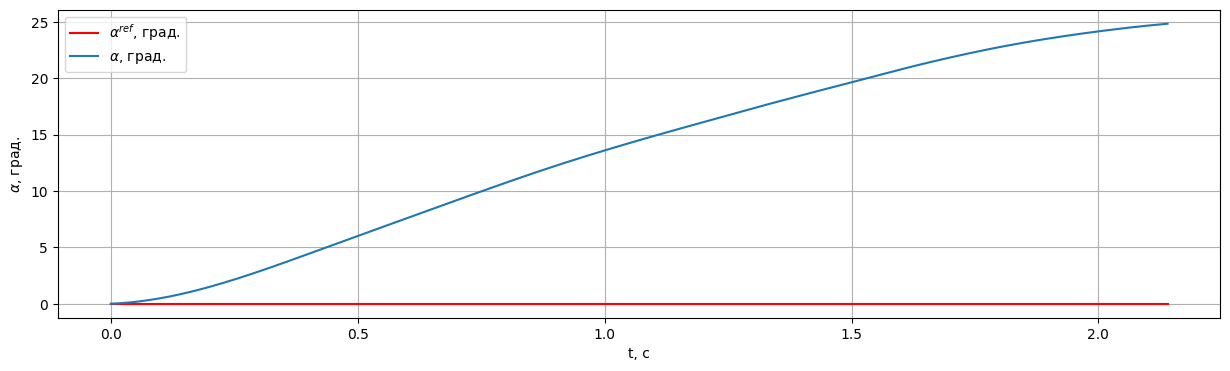

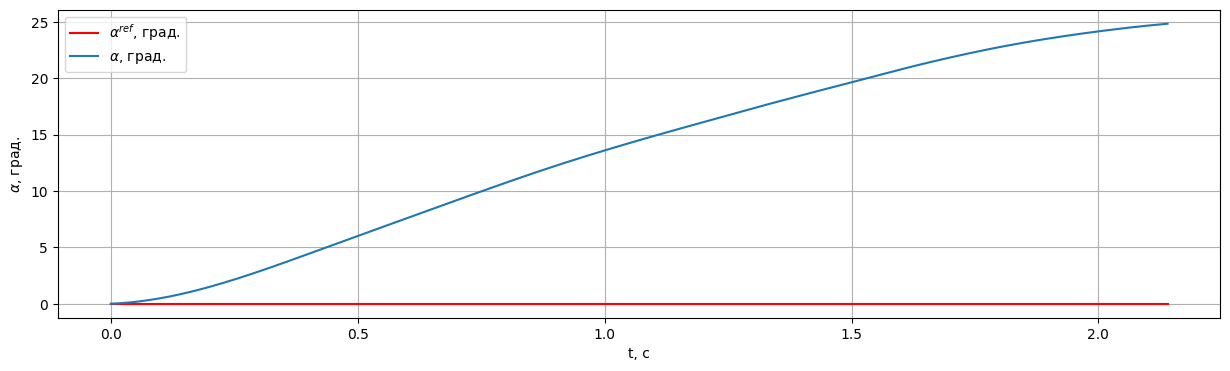

In [36]:
env.model.plot_transient_process('alpha', tps, reference_signals[0], to_deg=True, figsize=(15,4))